<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/4%EC%A3%BC%EC%B0%A8/transfer_learning_tutorial_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



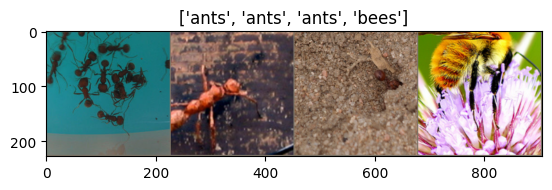

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [7]:
# 최종 완전 연결 계층을 재설정
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#정리
# Observe that all parameters are being optimized
#lr=0.001:초기 학습률 0.001/momentum=0.9:경사하강법에 추진력을 부여하여 훈련을 가속화하고 최적화 중에 진동을 완화하는 데 도움
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.7MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.7670 Acc: 0.5902
val Loss: 0.2477 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.3314 Acc: 0.8607
val Loss: 0.4138 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.5863 Acc: 0.7418
val Loss: 0.3351 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.5093 Acc: 0.7951
val Loss: 0.2443 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3915 Acc: 0.8320
val Loss: 0.2168 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5280 Acc: 0.7787
val Loss: 0.3786 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5136 Acc: 0.8074
val Loss: 0.2800 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3056 Acc: 0.8566
val Loss: 0.2189 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3768 Acc: 0.8320
val Loss: 0.1881 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3165 Acc: 0.8525
val Loss: 0.2329 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3671 Acc: 0.8443
val Loss: 0.1720 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2389 Acc: 0.9016
val Loss: 0.1737 Acc: 0.9346

Ep

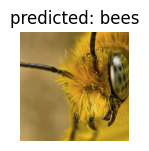

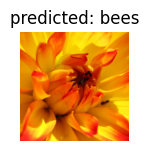

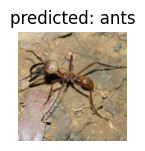

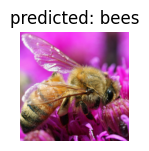

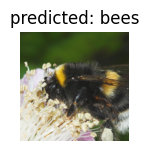

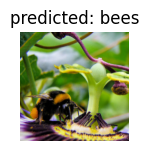

In [9]:
#시각
visualize_model(model_ft)

# **학습 정보(학습률,손실률,정확도)그래프로 나타내기**

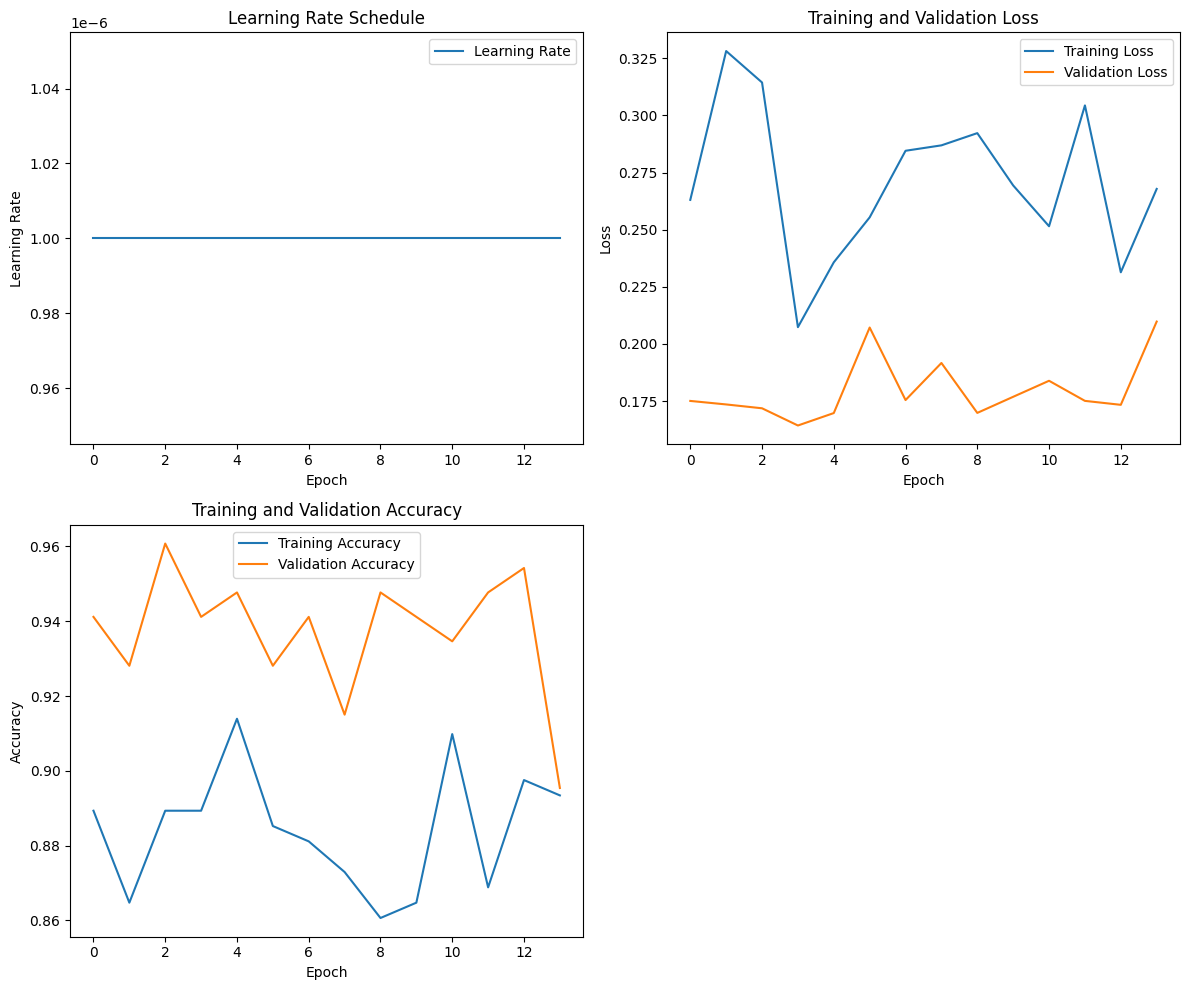

In [31]:
import matplotlib.pyplot as plt


# 2x2 subplot grid
plt.figure(figsize=(12, 10))

# Create the first subplot for the learning rate
plt.subplot(2, 2, 1)
plt.plot(range(len(lr_history)), lr_history, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

# Create the second subplot for training and validation loss
plt.subplot(2, 2, 2)
plt.plot(range(len(train_loss_history)), train_loss_history, label='Training Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Create the third subplot for training and validation accuracy
plt.subplot(2, 2, 3)
plt.plot(range(len(train_accuracy_history)), train_accuracy_history, label='Training Accuracy')
plt.plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**early stop일 경우**

Early stopping triggered.


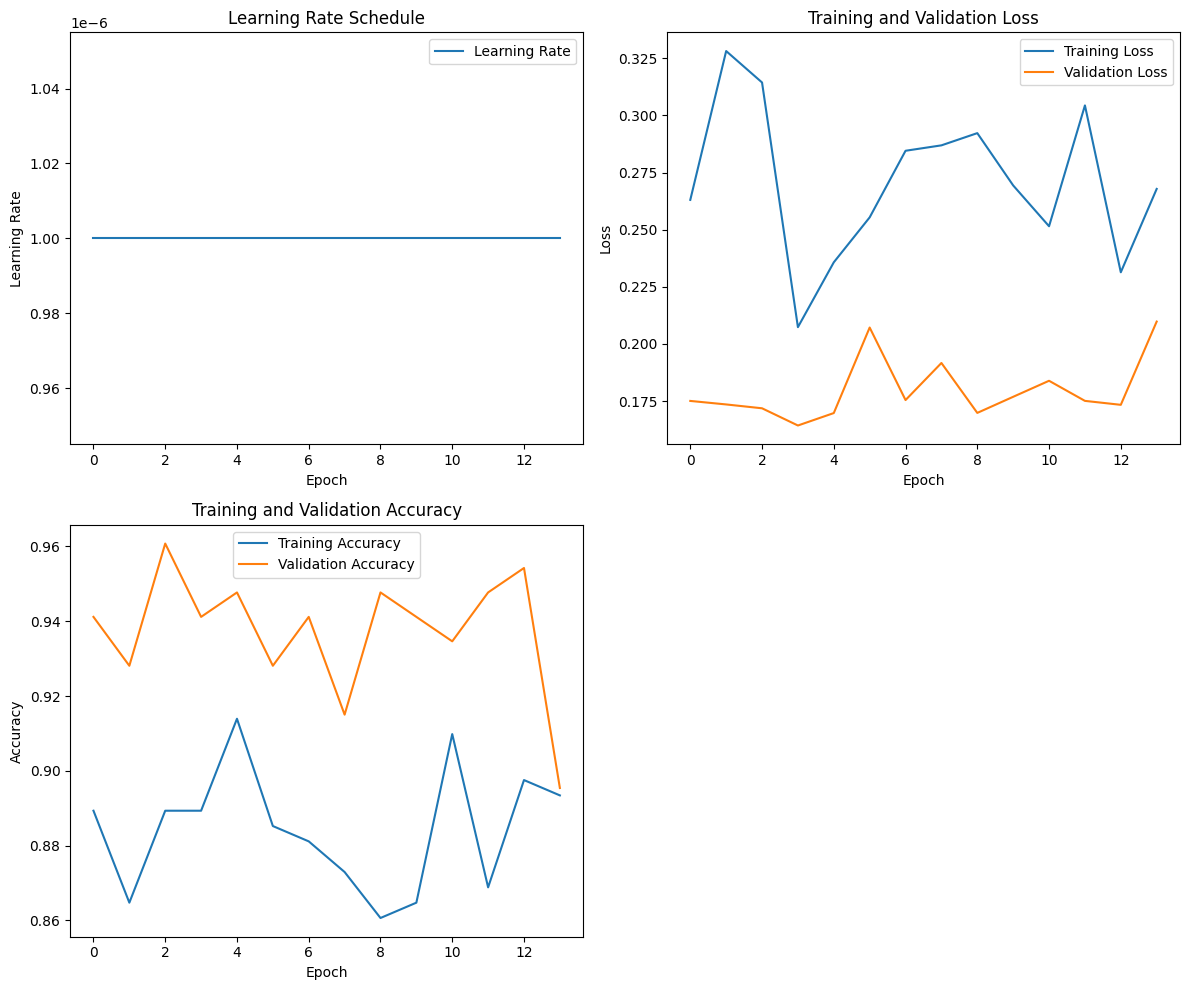

In [30]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Initialize lists to track metrics
lr_history = []
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Specify the number of epochs and early stopping parameters
num_epochs = 25
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_ft.zero_grad()

        # Forward pass
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / dataset_sizes['train']
    train_accuracy = correct / total

    # Record learning rate, training loss, and accuracy
    lr_history.append(optimizer_ft.param_groups[0]['lr'])
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation loop
    model_ft.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = val_loss / dataset_sizes['val']
    val_accuracy = val_correct / val_total

    # Record validation loss and accuracy
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# 2x2 subplot grid
plt.figure(figsize=(12, 10))

# Create the first subplot for the learning rate
plt.subplot(2, 2, 1)
plt.plot(range(len(lr_history)), lr_history, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

# Create the second subplot for training and validation loss
plt.subplot(2, 2, 2)
plt.plot(range(len(train_loss_history)), train_loss_history, label='Training Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Create the third subplot for training and validation accuracy
plt.subplot(2, 2, 3)
plt.plot(range(len(train_accuracy_history)), train_accuracy_history, label='Training Accuracy')
plt.plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [10]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7546 Acc: 0.5820
val Loss: 0.2540 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6141 Acc: 0.7213
val Loss: 0.2145 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5134 Acc: 0.7787
val Loss: 0.2669 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4100 Acc: 0.8115
val Loss: 0.2802 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4193 Acc: 0.8484
val Loss: 0.1819 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.5024 Acc: 0.7951
val Loss: 0.6442 Acc: 0.7843

Epoch 6/24
----------
train Loss: 0.4689 Acc: 0.8115
val Loss: 0.3575 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3676 Acc: 0.8566
val Loss: 0.1966 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3420 Acc: 0.8852
val Loss: 0.2012 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3707 Acc: 0.8607
val Loss: 0.1780 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3243 Acc: 0.8525
val Loss: 0.1977 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3755 Acc: 0.8361
val Loss: 0.2165 Acc: 0.9281

Ep

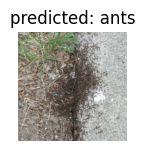

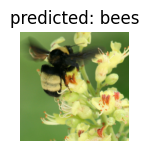

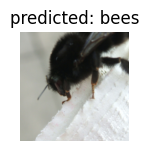

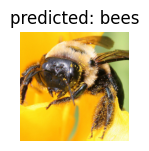

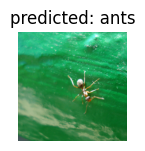

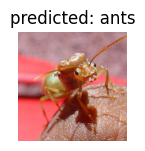

In [12]:
#시각화
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [13]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

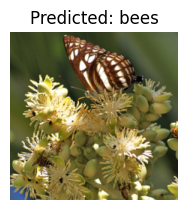

In [14]:
#시각화
visualize_model_predictions(
    model_conv,
    img_path='drive/MyDrive/hymenoptera_data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



